In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:

file = pd.read_csv('../data/Inplaydata19.csv', error_bad_lines=False)
dataFrame = pd.DataFrame(file)



In [3]:
# Single, Double, Triple, HomeRun, (field_out, force_out, fielders_choice) = out, 
# grounded_into_double_play, sac_fly, sac_bunt,

#Transform values into binary classification
d = {
    'single': 1, 
    'double': 1, 
    'triple': 1, 
    'home_run': 1, 
    'field_out': 0,
    'force_out': 0,
    'fielders_choice': 1,
    'grounded_into_double_play': 0,
    'sac_fly': 0,
    'sac_bunt': 0,
    'double_play': 0,
    'fielders_choice_out': 0,
    'catcher_interf': 1,
    'triple_play': 0,
    'field_error': 1,
    'sac_fly_double_play': 0,
    'sac_bunt_double_play': 0
}

dataFrame = dataFrame.replace(d)
#dataFrame=dataFrame.sample(frac=1).reset_index(drop=True)

In [4]:
X = pd.DataFrame()
dataFrame=dataFrame[dataFrame['hc_y']!=198]
dataFrame= dataFrame.dropna(subset=['launch_speed','launch_angle','hc_x','hc_y'])
dataFrame=dataFrame.sample(frac=1).reset_index()
batterlist=dataFrame['batter']
indexlist=dataFrame['index']
X['launch_speed'] = dataFrame['launch_speed']
X['launch_angle'] = dataFrame['launch_angle']*np.pi/180
X['launch_speed_angle'] = dataFrame['launch_speed_angle']
X['estimated_ba_using_speedangle'] = dataFrame['estimated_ba_using_speedangle']
X['hc_x']=125-dataFrame['hc_x']
X['hc_y']=198-dataFrame['hc_y']
X['events'] = dataFrame['events']
X.insert(0, 'Ones', 1)


y = X['events']

X = X.iloc[:, :-1]


In [5]:


X['hor_rad']=np.arctan(X['hc_x']/X['hc_y'])
X['hor_deg']=X['hor_rad']*(180/np.pi)

In [6]:
meanspd=np.mean(X['launch_speed'])
stdspd=np.std(X['launch_speed'])
meanang=np.mean(X['launch_angle'])
stdang=np.std(X['launch_angle'])
stdhor=np.std(X['hor_rad'])


In [85]:
normX=pd.DataFrame()
normX['launch_speed']=(X['launch_speed']-meanspd)/stdspd
normX['launch_angle']=(X['launch_angle']-meanang)/stdang
normX['hor_angle']=(X['hor_rad'])/stdhor

## SVM Stuff

In [8]:
#Trim data
normX=normX.iloc[:,:3]
sliceX = normX.iloc[0:800]
slicey = y.iloc[0:800]
sliceX2 = normX.iloc[5000:10000]
slicey2 = y.iloc[5000:10000]

In [ ]:
hyperparams = { 
    'C': np.linspace(1, 100, 100),
    'gamma': np.linspace(0.00, 5, 100),
    'class_weight': ['balanced', None],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

rs = RandomizedSearchCV(svm.SVC(), hyperparams, cv=10, n_iter=25, verbose=2, scoring='accuracy',n_jobs=-1)
rs.fit(sliceX, slicey)
print(rs.best_params_)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] kernel=poly, gamma=1.1111111111111112, class_weight=None, C=30.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
rbf_svc = svm.SVC(kernel='rbf', C=68, gamma=0.55, class_weight='balanced')
scoresRBF = cross_val_score(rbf_svc, sliceX, slicey, cv=10, scoring='accuracy')
print(np.mean(scoresRBF))

## Random Forest

In [9]:
rf_hyperparams = { 
    'n_estimators': np.arange(100, 1000, 10),
    'max_features': ['auto', 'sqrt'],
    'max_depth': np.arange(10,100,10),
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'bootstrap':[True,False]
    
}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, rf_hyperparams, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(sliceX,slicey)
print(rf_random.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   44.0s finished


{'n_estimators': 640, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}


In [10]:

bestpar = rf_random.best_params_
rf=RandomForestClassifier(n_estimators=bestpar['n_estimators'],min_samples_split=bestpar['min_samples_split'],
                         min_samples_leaf=bestpar['min_samples_leaf'],max_depth=bestpar['max_depth'],max_features=bestpar['max_features'],
                        bootstrap=bestpar['bootstrap'],n_jobs=-1, random_state=42)


In [11]:
scores_rf = cross_val_score(rf, sliceX2, slicey2, cv=10, scoring='accuracy')
classifier=rf.fit(sliceX,slicey)
print(np.mean(scores_rf))

0.7959860815443262


In [86]:
results=pd.DataFrame()
predictions=classifier.predict_proba(normX)
results['launch_speed']=normX['launch_speed']*stdspd+meanspd
results['launch_angle']=normX['launch_angle']*stdang+meanang
results['hor_angle']=normX['hor_angle']*stdhor
results['predictions']=predictions[:,1]

In [87]:
results.head()

,launch_speed,launch_angle,hor_angle,predictions
0,74.3,-0.130900,-0.499192,0.009375
1,88.2,0.727802,-0.663962,0.043750
2,108.2,0.141372,0.152431,0.926562
3,100.2,-0.186750,0.382924,0.726562
4,75.4,0.097738,-0.528456,0.173437


## Aggregation by Player

In [13]:
normX=normX.iloc[:,:3]
normX['predictions']=classifier.predict_proba(normX)[:,1]


In [14]:
normX['batter']=batterlist
#normX['regspeed']=normX['launch_speed']*stdspd+meanspd
#normX['reglang']=normX['launch_angle']*stdang+meanang
#normX['reghang']=normX['hor_angle']*stdhor

In [15]:
pred=pd.DataFrame()
pred['batter']=normX['batter']
pred['predictions']=normX['predictions']

In [16]:
grouped=pred.groupby('batter')

In [17]:
predictor=pd.DataFrame()
#predictor['batter']=grouped.describe()['batter']
predictor['count']=grouped.describe()['predictions']['count']
predictor['exba']=grouped.describe()['predictions']['mean']
predictor=predictor.reset_index()

In [97]:

batters=pd.read_csv('../data/batterdat1.csv')
strikeouts=pd.read_csv('../data/Strikeouts.csv')
batters['Name']=batters['player_name']
full=strikeouts.merge(batters,on='Name',how='outer')
full=full.dropna()
#joiner=pd.DataFrame()
#joiner['batter']=full['player_id']
#joiner['Name']=full['Name']
#joiner['Team']=full['Team']
#joiner['AB']=full['AB']
#joiner['Batting_Avg']=full['ba']
full['batter']=full['player_id']
predictor=predictor.merge(full,on='batter',how='inner')
#predictor['Ex ABs']=predictor['count']

In [98]:
predictor.head()

,batter,count,exba,Name_x,Name_y,Strikeouts,Batting_Avg_x,Name_x,Team_x,AB_x,...,playerid,player_id,player_name,ba,babip,woba,xwoba,abs,launch_speed,launch_angle
0,405395,428.0,0.332955,Albert Pujols,Albert Pujols,68.0,0.244,Albert Pujols,Angels,491.0,...,1177.0,405395.0,Albert Pujols,0.244,0.238,0.312,0.319,491.0,84.7,15.3
1,408234,389.0,0.371574,Miguel Cabrera,Miguel Cabrera,108.0,0.282,Miguel Cabrera,Tigers,493.0,...,1744.0,408234.0,Miguel Cabrera,0.282,0.336,0.321,0.332,493.0,84.8,16.4
2,425783,398.0,0.406423,Shin-Soo Choo,Shin-Soo Choo,165.0,0.265,Shin-Soo Choo,Rangers,563.0,...,3174.0,425783.0,Shin-Soo Choo,0.265,0.333,0.357,0.356,563.0,85.4,13.7
3,430945,385.0,0.350280,Adam Jones,Adam Jones,101.0,0.260,Adam Jones,Diamondbacks,485.0,...,6368.0,430945.0,Adam Jones,0.260,0.296,0.312,0.314,485.0,81.8,15.6
4,443558,324.0,0.436651,Nelson Cruz,Nelson Cruz,131.0,0.311,Nelson Cruz,Twins,454.0,...,2434.0,443558.0,Nelson Cruz,0.311,0.351,0.423,0.418,454.0,87.8,15.8


In [19]:
predictor.head()

,batter,count,exba,Name
0,282332,1.0,0.415625,CC Sabathia
1,400085,4.0,0.103516,Ichiro Suzuki
2,405395,428.0,0.332955,Albert Pujols
3,408234,389.0,0.371574,Miguel Cabrera
4,425772,142.0,0.303114,Jeff Mathis


## Charts

### Launch Speed v Vert Angle

In [66]:
testX=np.linspace(-2,2,40) # (minsd,maxsd,numpoints) Launch Speed
testy=np.linspace(-2,2,40) # (minsd,maxsd,numpoints) Launch Angle
a=[]
b=[]
for i in testX:
    for z in testy:
        a.append(i)
        b.append(z)

In [67]:
defhor=10 #default Horizontal Angle
samp=pd.DataFrame()
samp['launch_speed']=a
samp['launch_angle']=b
samp['hor_angle']=np.pi*defhor/(stdhor*180)
predictionsb=classifier.predict_proba(samp)
test=pd.DataFrame()
test['predictions']=predictionsb[:,1]
test['regspeed']=samp['launch_speed']*stdspd+meanspd
test['reglang']=samp['launch_angle']*stdang+meanang

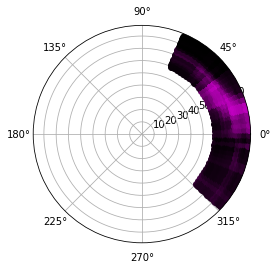

In [73]:
plt.figure()
color = [[0,0,0]]
for i in range(0,800):
    colored=test['predictions'][i]
    color=[colored,0,colored] # where we change color plots
    plt.polar(test.loc[i, 'reglang'], test.loc[i, 'regspeed'],c=color,marker='o')
plt.show()

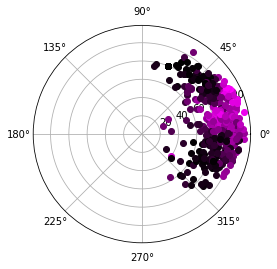

In [80]:

plt.figure()
color = [[0,0,0]]
for i in range(2400,2800):
    colored=results['predictions'][i]
    color=[colored,0,colored] # where we change color plots
    plt.polar(results.loc[i, 'launch_angle'], results.loc[i, 'launch_speed'],c=color,marker='o')
plt.show()

### Launch Speed v Horizontal Angle

In [63]:
testX=np.linspace(-2,2,40)# (minsd,maxsd,numpoints) Launch Speed
testy=np.linspace(-1.5,1.5,30)# (minsd,maxsd,numpoints) Horizontal Angle
a=[]
b=[]
for i in testX:
    for z in testy:
        a.append(i)
        b.append(z)

In [69]:
deflaunch=20 #default Vertical Launch Angle
samp2=pd.DataFrame()
samp2['launch_speed']=a
samp2['launch_angle']=((np.pi*deflaunch/180)-meanang)/stdang
samp2['hor_angle']=b
predictionsb=classifier.predict_proba(samp2)
test2=pd.DataFrame()
test2['predictions']=predictionsb[:,1]
test2['regspeed']=samp2['launch_speed']*stdspd+meanspd
test2['reghang']=samp2['hor_angle']*stdhor

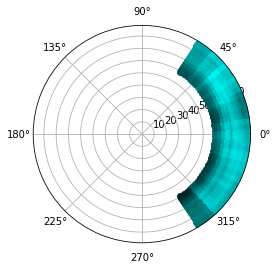

In [70]:
plt.figure()
color = [[0,0,0]]
for i in range(0,800):
    colored=test2['predictions'][i]
    color=[0,colored,colored] #where we change color plots
    plt.polar(test2.loc[i, 'reghang'], test2.loc[i, 'regspeed'],c=color,marker='o')
plt.show()

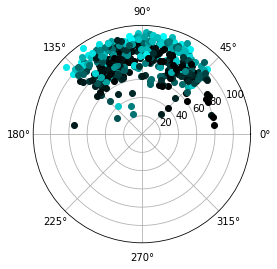

In [90]:
plt.figure()
color = [[0,0,0]]
for i in range(2400,2800):
    colored=results['predictions'][i]
    color=[0,colored,colored] # where we change color plots
    plt.polar(results.loc[i, 'hor_angle']+np.pi/2, results.loc[i, 'launch_speed'],c=color,marker='o')
plt.show()